In [1]:
import pandas as pd
import numpy as np

from datetime import timedelta, datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import acquire
from acquire import get_items, get_stores, get_sales, get_full_data, get_germany_data
import prepare
from prepare import clean_store, clean_germany

from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
%matplotlib inline

import seaborn as sns
plt.rc('figure', figsize=(13, 7))
# plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('fivethirtyeight')

Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. For both datasets you should choose a method of splitting your data and only explore the training split.

In [2]:
#acquire df
df = get_full_data()

df.head(1)

,Unnamed: 0_x,item,sale_amount,sale_date,sale_id,store,Unnamed: 0_y,store_address,store_city,store_id,store_state,store_zipcode,Unnamed: 0,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,0,1,13.00,"Tue, 01 Jan 2013 00:00:00 GMT",1,1,0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013


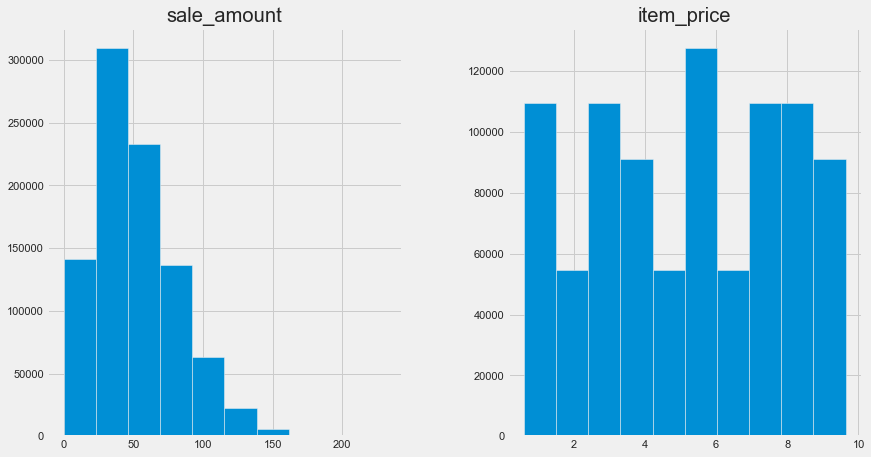

,store_id,item_id,sale_id,sale_amount,item_upc14,item_upc12,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,1,1,13.00,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,Tuesday,10.92
2013-01-01 00:00:00+00:00,7,12,211817,26.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,12018 Perrin Beitel Rd,78217,San Antonio,TX,1,Tuesday,218.40
2013-01-01 00:00:00+00:00,7,46,832657,27.00,35457770664,35457770664,Mama Marys,Pizza Sauce,4.65,12018 Perrin Beitel Rd,78217,San Antonio,TX,1,Tuesday,125.55
2013-01-01 00:00:00+00:00,8,12,213643,54.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,15000 San Pedro Ave,78232,San Antonio,TX,1,Tuesday,453.60
2013-01-01 00:00:00+00:00,9,12,215469,35.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,735 SW Military Dr,78221,San Antonio,TX,1,Tuesday,294.00


In [3]:
#prepare df
df = clean_store(df)
df.head()

In [4]:
print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

Date Range: 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Shape: (913000, 16)


In [5]:
#split data (percentage-based)
#using 70/30 train test split %

train_size = .70
n = df.shape[0] 
test_start_index = round(train_size * n) 
test_start_index #the first 639,100 rows will be set as train

639100

In [6]:
# create train and test dataframe

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

train.shape, test.shape


((639100, 16), (273900, 16))

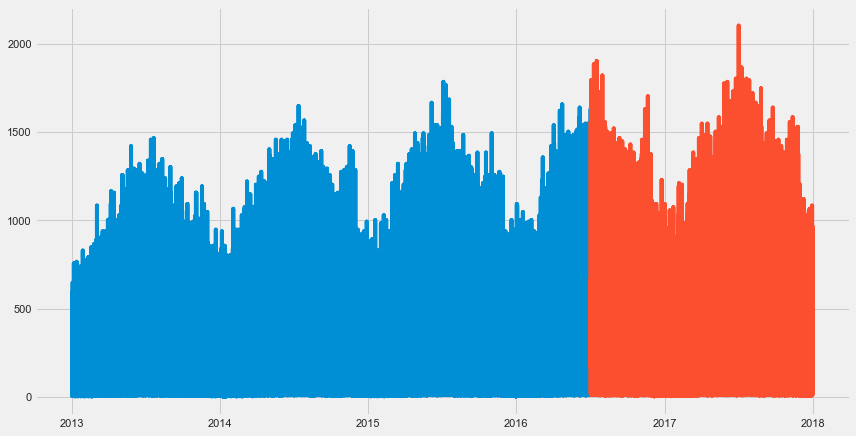

In [7]:
#plot train and test

plt.plot(train.index, train.sales_total) 
plt.plot(test.index, test.sales_total)

In [8]:
# create a series called 'y' 

y = train.sales_total
y.head()

sale_date
2013-01-01 00:00:00+00:00    10.92
2013-01-01 00:00:00+00:00   218.40
2013-01-01 00:00:00+00:00   125.55
2013-01-01 00:00:00+00:00   453.60
2013-01-01 00:00:00+00:00   294.00
Name: sales_total, dtype: float64

<AxesSubplot:ylabel='Frequency'>

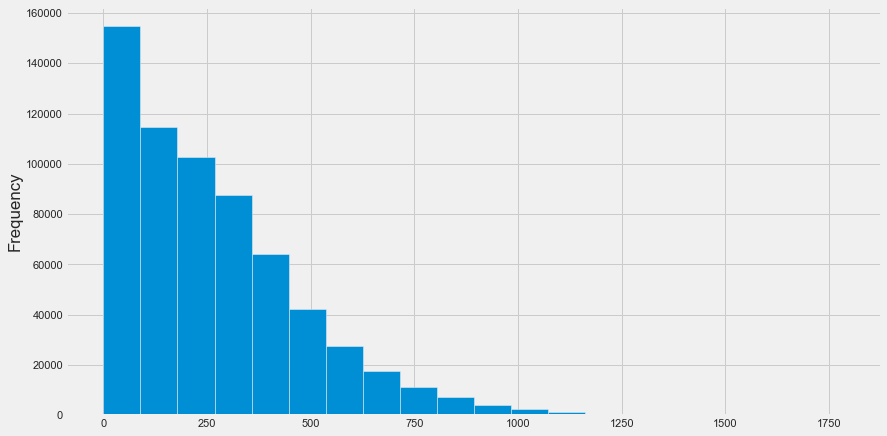

In [9]:
#histogram of sales_total
y.plot.hist(bins=20)

In [10]:
#making a new col for 'year'
train['year'] = y.index.year
train.head()

,store_id,item_id,sale_id,sale_amount,item_upc14,item_upc12,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state,month,day_of_week,sales_total,year
sale_date,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,1,1,1,13.00,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,Tuesday,10.92,2013
2013-01-01 00:00:00+00:00,7,12,211817,26.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,12018 Perrin Beitel Rd,78217,San Antonio,TX,1,Tuesday,218.40,2013
2013-01-01 00:00:00+00:00,7,46,832657,27.00,35457770664,35457770664,Mama Marys,Pizza Sauce,4.65,12018 Perrin Beitel Rd,78217,San Antonio,TX,1,Tuesday,125.55,2013
2013-01-01 00:00:00+00:00,8,12,213643,54.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,15000 San Pedro Ave,78232,San Antonio,TX,1,Tuesday,453.60,2013
2013-01-01 00:00:00+00:00,9,12,215469,35.00,74676640211,74676640211,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,735 SW Military Dr,78221,San Antonio,TX,1,Tuesday,294.00,2013


In [12]:
train.groupby('year').sales_total.mean()

year
2013   233.97
2014   269.11
2015   280.97
2016   291.63
Name: sales_total, dtype: float64

<AxesSubplot:xlabel='year'>

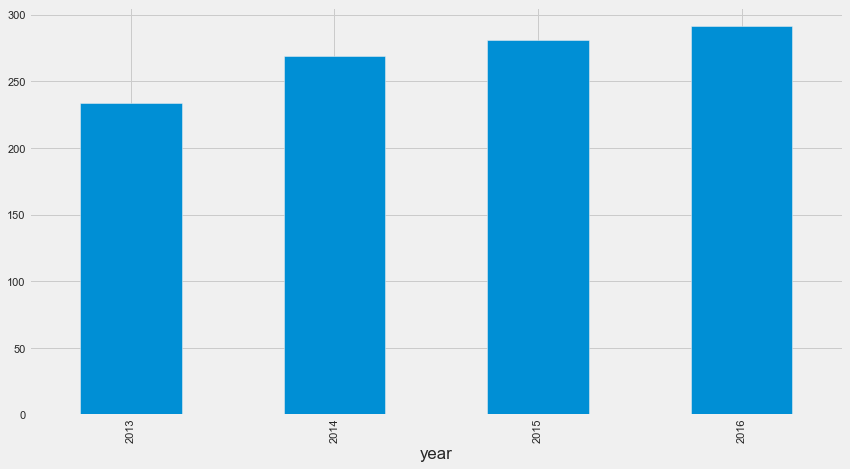

In [13]:
# Plot mean sales by year (bar plot)

train.groupby('year').sales_total.mean().plot.bar()

<AxesSubplot:xlabel='day_of_week'>

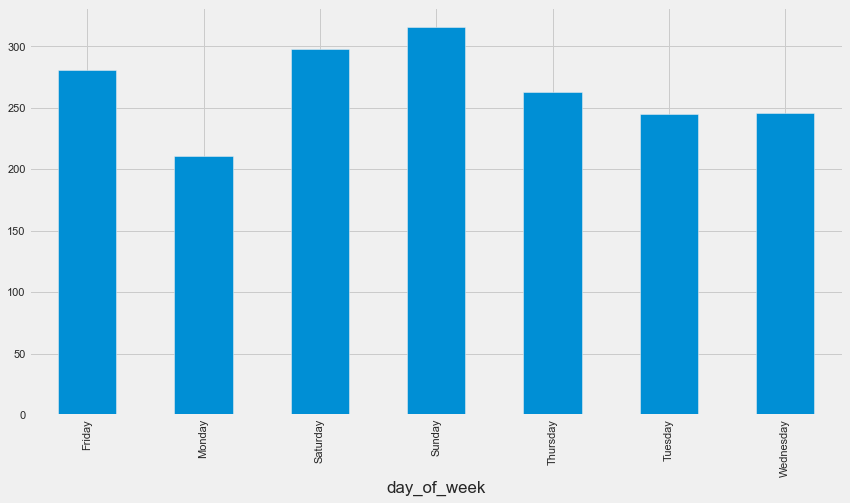

In [14]:
# Plot mean sales by weekday

train.groupby('day_of_week').sales_total.mean().plot.bar()

<AxesSubplot:xlabel='day_of_week', ylabel='sales_total'>

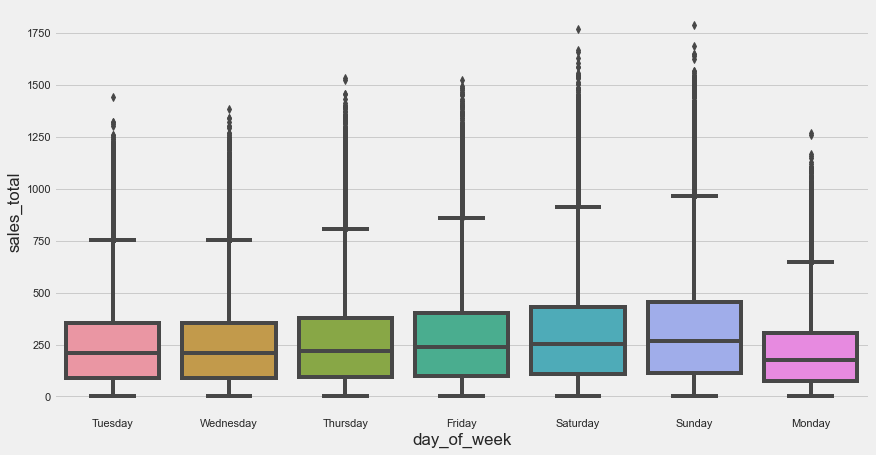

In [15]:
sns.boxplot(data = train, x = 'day_of_week', y = 'sales_total')
